# Liver Model Construction: Notebook-Glycogenolysis

## Setup workflow

### Import packages

In [1]:
import os
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


## Set paths and constants

In [2]:
seed = int(4)
#increase number of models from before
n_models = 20

mass_config = MassConfiguration()
mass_config.solver = "cplex"

### Directory paths

In [3]:
#had to remove the mass
model_dir = os.path.abspath("../models")
maps_dir = os.path.abspath("../maps")
data_dir = os.path.abspath("../data")

In [4]:
# Allow Escher to close without pop-up
escher.rc['never_ask_before_quit'] = True


### Load COBRA model

In [5]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x022853ba2be0
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [6]:
# core_model.reactions.remove_from_model()

core_model.reactions.EX_glc__D_c.remove_from_model()


In [7]:
## adding reactions from Recon3D
R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [8]:
## adding reactions from glycogenloysis 
gly=load_json_cobra_model(filename=os.path.join(model_dir,"Glycogenolysis.json"))

In [9]:
## change after double checking this, maybe not needed to be added to core?
a= R3D.reactions.EX_glc__D_e
b= R3D.reactions.GLCt1
g= gly.reactions.SK_g6p_c
new_r_list=[
            a,
            b,
            g
    
]


In [10]:
for x in new_r_list:
    c= x
    core_model.add_reaction(c)

In [11]:
core_model.reactions.GLCt1

Reaction identifier,GLCt1
Name,Glucose transport uniport
Memory address,0x02285c49ac70
Stoichiometry,glc__D_e <=> glc__D_c D-Glucose <=> D-Glucose
GPR,66035_AT1 or 6517_AT1 or 56606_AT1 or 154091_AT1 or 6513_AT1 or 11182_AT1 or 29988_AT1 or 6514_AT...
Lower bound,-1000.0
Upper bound,1000.0


## View Escher map

In [12]:
#view all the reactions that we need build
escher_builder = escher.Builder(
    model=core_model,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder


Builder(highlight_missing=True, never_ask_before_quit=True)

### Loading Measured Fluxes

In [13]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [14]:
#define data sheet as latest data sheet
data_sheet=os.path.join(data_dir,"1.12-ma-data-collection-glycogenolysis.xlsx")

flux_df = load_data(
    filepath=data_sheet,
    sheet_name="Fluxes").drop("Fasting Time", axis=1).drop("Additional Notes", axis=1).drop("Unnamed: 4", axis=1).drop("Unnamed: 5", axis=1)
    ## weird anomaly, shouldn't happen * unnames:4 and 5

flux_df = flux_df.dropna() #drops rows with NaN
flux_df


,Flux (mmol/gDW*hr)
ID,
GLCter,-0.001682
G6PPer,0.001682
G6Pter,0.001682
GLPASE1,0.000223
PGMT,0.000223
EX_glygn2_c,-0.000223
GAPD,-0.002919
PGK,0.002919
PGM,0.002919


In [15]:
v_vars = []
v_data = []

# How much flux to allow through irreversible reaction pairs
# e.g, PFK/FBP & reverse_flux_percent = 0.1, raise both fluxes by 10% of non-zero flux value
reverse_flux_percent = 0.1
irreversible_enzyme_pairs = ["PFK", "FBP"]

In [16]:
core_model.reactions

[<Reaction CSm at 0x22853e673a0>,
 <Reaction ACONTm at 0x228517c49a0>,
 <Reaction ICDHxm at 0x22853e67370>,
 <Reaction AKGDm at 0x22853e673d0>,
 <Reaction SUCOASm at 0x22853e67400>,
 <Reaction SUCD1m at 0x2283c00b520>,
 <Reaction FUMm at 0x22853f68d90>,
 <Reaction MDHm at 0x22853f68dc0>,
 <Reaction NADH2_u10mi at 0x22853e70cd0>,
 <Reaction FADH2ETC at 0x22853f79e50>,
 <Reaction CYOR_u10mi at 0x22853f79520>,
 <Reaction CYOOm2i at 0x22853f79b50>,
 <Reaction ATPS4mi at 0x22853f79ac0>,
 <Reaction Htmi at 0x22853f98430>,
 <Reaction HEX1 at 0x22853f98820>,
 <Reaction PGI at 0x22853f98040>,
 <Reaction PFK at 0x22853f98400>,
 <Reaction FBA at 0x22853f98190>,
 <Reaction TPI at 0x22853f987f0>,
 <Reaction GAPD at 0x22853fa7970>,
 <Reaction PGK at 0x22853fa7b20>,
 <Reaction PGM at 0x22853f83910>,
 <Reaction ENO at 0x22853f83dc0>,
 <Reaction PYK at 0x2285411c880>,
 <Reaction ADK1 at 0x2285411c610>,
 <Reaction PDHm at 0x2285411c1f0>,
 <Reaction LDH_L at 0x22853f97070>,
 <Reaction G6PDH2r at 0x22853f

In [17]:
for rid, flux in flux_df.itertuples():
    reaction = core_model.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    #set bounds for all boundary reactions 
    #uptake --> (-value, 1000)
    #secretion --> (-1000 --> value)
    #reversible --> (-1000,1000)
    if (rid == "EX_lac__L_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (0,1000) 
    elif (rid == "EX_glc__L_e"): #secretion
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (-1000, 0) 
    elif (rid == "EX_pyr_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (0, 1000) 
    elif (rid == "EX_glygn2_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (-1, 1000) 
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_df.loc[irreversible_enzyme_pairs, "Flux (mmol/gDW*hr)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
   
    #address irreversible enzyme pair boundary reactions if necessary

    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)
    
#print(v_vars)
#print(v_data)


GLCter -0.001682007621
G6PPer 0.001682007621
G6Pter 0.001682007621
GLPASE1 0.0002227316028
PGMT 0.0002227316028
EX_glygn2_c -0.0002227316028
GAPD -0.002918552036
PGK 0.002918552036
PGM 0.002918552036
ENO -0.002918552036
PEPCKm 0.00487705406
PCm 0.004685044058
LDH_L 0.002726542034
PYK 0.001950821624
ME2 0.001950821624
CSm 0.002903191236
MDHm 0.003095201238
EX_glc__D_e 0.001682007621
GLCt1 -0.001682007621
EX_lac__L_c -0.0005484158966
EX_pyr_c -7.774254584e-05
TPI 0.0
FBA -0.002918552036
FBP 0.0032104072395999998
PFK 0.0002918552036
PGI -0.002918552036


In [18]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
core_model.objective = objective[0]
core_model.objective_direction = "min"

flux_solution = core_model.optimize()

In [19]:
flux_solution

,fluxes,reduced_costs
CSm,0.000657,0.004492
ACONTm,0.000657,0.000000
ICDHxm,0.000657,0.000000
AKGDm,0.000657,0.000000
SUCOASm,-0.000657,0.000000
...,...,...
EX_glyc_3octa_c,-0.000000,0.000000
EX_fru_c,0.000000,0.032422
EX_glc__D_e,0.001690,-0.000016
GLCt1,-0.001690,0.003364


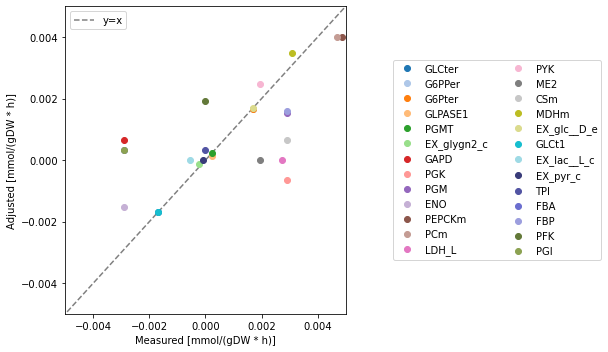

In [20]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux (mmol/gDW*hr)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.005,0.005), ylim=(-0.005, 0.005),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


## Create MASS model

In [21]:
glycogenolysis = MassModel("Glycogenolysis", array_type='DataFrame', dtype=np.int64)
glycogenolysis

Name,Glycogenolysis
Memory address,0x022855335c10
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [22]:
#add reactions one at a time
reaction_list=[]
reaction_list = ['HEX1',
                  'GLCt1'
#                  'G6Pter',
#                  'G6PPer'
#                 #'PGI',
#                 #'FBP',
#                 'PFK',
#                 'FBA',
#                 'TPI',
#                 'GAPD',
#                 'PGK',
#                 'PGM',
#                 'ENO',
#                 #'PEPtm',
#                 #'PEPCKm',
#                 #'LDH_L',
#                 'PYK'
#                 #'PCm',
#                 #'PYRt2m'
                ]

# a= R3D.reactions.EX_glc__D_e
# b= R3D.reactions.GLCt1
# g= gly.reactions.SK_g6p_c
# new_r_list=[
#             a,
#             b,
#             g
    
# ]


In [23]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = core_model.reactions.get_by_id(rid)
    glycogenolysis.add_reactions([MassReaction(reaction)])

In [24]:
flux_solution

,fluxes,reduced_costs
CSm,0.000657,0.004492
ACONTm,0.000657,0.000000
ICDHxm,0.000657,0.000000
AKGDm,0.000657,0.000000
SUCOASm,-0.000657,0.000000
...,...,...
EX_glyc_3octa_c,-0.000000,0.000000
EX_fru_c,0.000000,0.032422
EX_glc__D_e,0.001690,-0.000016
GLCt1,-0.001690,0.003364


##  Set Fluxes

In [25]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycogenolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 
    # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 0.0013421134913894743
v_GLCt1: -0.0021610252702108745


## Set Keqs

In [26]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io=data_sheet,
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1).drop('Keq unit', axis=1)

Keq_df = Keq_df.dropna() #drops rows with NaN
Keq_df

Keq_df

,Equlibrium Constant
Reaction,
GLCt1,1.000000
HEX1,3000.000000
G6PPer,41.300000
G6Pter,2.761096
GLCter,1.000000


In [27]:
Keq_list =[]
for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycogenolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))

Keq_GLCt1: 1.0
Keq_HEX1: 3000.0


## Set H2O/H Constants

In [28]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
#     "h2o_c",
    "h_c",
#     "glc__D_e",
#     'h20_r'
    
       #'h_i'
       #'h_m' 
    #remove h_i and h_m if not mitochondrial reactions
                  ]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

## Obtain Concentrations

In [29]:
#Load Concentration Data
conc_df = load_data(
    filepath=data_sheet,
    sheet_name="Concentrations").drop("Concentration (mM)", axis=1)
#conc_df = conc_df.drop("Name", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)
conc_df = conc_df.dropna() #drops rows with NaN
conc_df

,Name,Concentration(M)
ID,,
glc__D_c,D-Glucose,0.010483
atp_c,ATP C10H12N5O13P3,0.004727
adp_c,ADP C10H12N5O10P2,0.001995
g6p_c,D-Glucose 6-phosphate,0.000140
g6p_r,D-Glucose 6-phosphate,0.000387
pi_r,Phosphate,0.009744


In [30]:
#Set Concentrations

metabolite_list = [
# HEX1    
    'glc__D_c',
    'g6p_c',
    'adp_c',
    'atp_c',
    #'pi_c',
    'h_c',
# GLCt1
    'glc__D_e'
# #G6Pter
#             'g6p_r',
# #G6PPer 
#             'h2o_r',
#             'glc__D_r',
#             'pi_r'
            
                  ]

In [31]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycogenolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        met_list.append(metabolite.ic)

In [32]:
for metabolite in [
    #'h_i',
    #'h_m',
    "h_c", 
    #"h2o_c"
#'h20_r'
]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M
    
glycogenolysis.metabolites.glc__D_e.ic= glycogenolysis.metabolites.glc__D_c.ic

for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: 1
glc__D_e: 0.01048280703


In [33]:
#Formulate QP minimization list for concentrations
## double check this?
conc_solver = ConcSolver(
    glycogenolysis, # bc only want metabolites in glycogenolysis 
    excluded_metabolites=[
        #'h_i', 'h_m', 'co2_m', 'gdp_m', 'gtp_m', 'hco3_m'
        "h_c", 
        #"h2o_c",'13dpg_c'
    ],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycogenolysis.fixed))
fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
adp_c,0.001995,0.0
atp_c,0.004727,0.0
g6p_c,0.000140,0.0
glc__D_c,0.014630,0.0
glc__D_e,0.007511,0.0
Keq_HEX1,3000.000000,0.0
Keq_GLCt1,0.716531,0.0


mass\visualization\visualization_util.py:1269 UserWarning: Ignoring {'pi_r', 'g6p_r'}, only in one set of given values
mass\visualization\visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass\visualization\visualization_util.py:806 UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


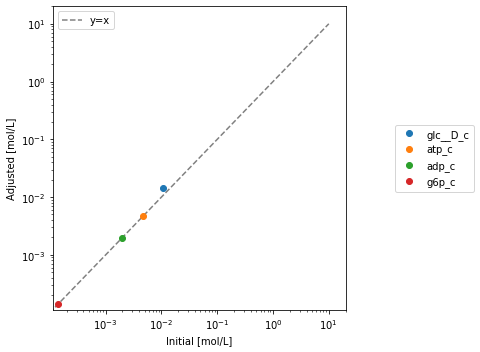

In [34]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration(M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(0, 20), ylim=(0, 20), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycogenolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations

In [35]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycogenolysis.fixed),
    fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycogenolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,adp_c,atp_c,g6p_c,glc__D_c,glc__D_e
0,0.003654,0.001531,0.000111,0.006823,0.001107
1,0.000571,0.001135,0.000789,0.012839,0.003689
2,0.010671,0.001391,0.000066,0.002028,0.000848
3,0.014204,0.006498,0.000314,0.053941,0.002023
4,0.007301,0.002004,0.000104,0.062034,0.001812


## Set concentrations and balance models with pseudoreactions

In [36]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycogenolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)
        
        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))
print(models_for_ensemble)

Number of models in ensemble: 20
[<MassModel Glycogenolysis_C0 at 0x2285bf8f280>, <MassModel Glycogenolysis_C1 at 0x2285c024220>, <MassModel Glycogenolysis_C2 at 0x2285c756f10>, <MassModel Glycogenolysis_C3 at 0x2285bbf2490>, <MassModel Glycogenolysis_C4 at 0x2285b995f40>, <MassModel Glycogenolysis_C5 at 0x2285b3baac0>, <MassModel Glycogenolysis_C6 at 0x2285b075910>, <MassModel Glycogenolysis_C7 at 0x2285a9077f0>, <MassModel Glycogenolysis_C8 at 0x228597283a0>, <MassModel Glycogenolysis_C9 at 0x2285940cc70>, <MassModel Glycogenolysis_C10 at 0x228579e7be0>, <MassModel Glycogenolysis_C11 at 0x2285c789a00>, <MassModel Glycogenolysis_C12 at 0x2285ac03b80>, <MassModel Glycogenolysis_C13 at 0x2285c7942e0>, <MassModel Glycogenolysis_C14 at 0x22859bd6730>, <MassModel Glycogenolysis_C15 at 0x2285a2df7c0>, <MassModel Glycogenolysis_C16 at 0x2285784a7f0>, <MassModel Glycogenolysis_C17 at 0x2285bb20250>, <MassModel Glycogenolysis_C18 at 0x2285751f580>, <MassModel Glycogenolysis_C19 at 0x2285c20440

In [37]:
## determine imbalances in the reduced network
fluxes = np.array(list(glycogenolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycogenolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0:
        continue
    # Get metabolite object
    met = glycogenolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycogenolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance
    try:
        # Update PERCs
        glycogenolysis.calculate_PERCs(
            fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not r.boundary},
            update_reactions=True)
    except:
        print("Negative PERCs for {0}".format(new_model.id))
        continue

In [38]:
## balancing charges on reactions manually

glycogenolysis.metabolites.h_c.charge=1

In [39]:
qcqa_model(glycogenolysis, parameters=True, concentrations=True,
          fluxes=True, superfluous=True, elemental=True)


╒══════════════════════════════════════════╕
│ MODEL ID: Glycogenolysis                 │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


In [42]:
glycogenolysis.genes
#for x in range(len(glycogenolysis.genes)):
#    a= glycogenolysis.genes[x]
#    glycogenolysis.genes.remove(a)


[]

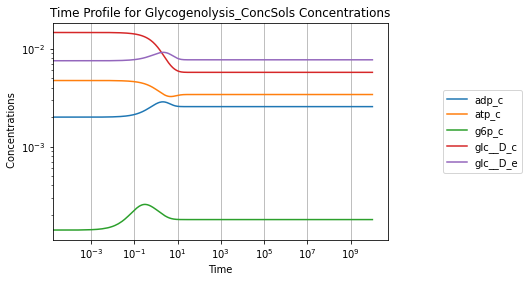

In [45]:
###RUN THIS FOR TIME PROFILE
# Setup simulation object
sim = Simulation(glycogenolysis, verbose=False)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycogenolysis, time=(0, 1e10, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

## Perturbation/Validation


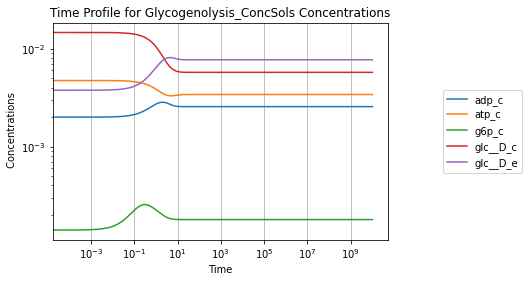

In [46]:
#perturbing it with half the amount of blood glucose --> literature
conc_sol, flux_sol = sim.simulate(glycogenolysis, time=(0, 1e10, 1e4 + 1), 
    perturbations={"glc__D_e": "glc__D_e * 0.5"})

conc_sol.view_time_profile()

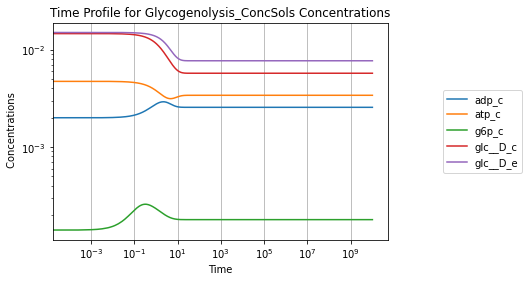

In [48]:
#perturbing it with double the amount of blood glucose --> literature
conc_sol, flux_sol = sim.simulate(glycogenolysis, time=(0, 1e10, 1e4 + 1), 
    perturbations={"glc__D_e": "glc__D_e * 2"})

conc_sol.view_time_profile()

In [ ]:
fig_1, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}
plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [mM]",
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Flux [mol/L*hr]",
    title=("Flux Profile", L_FONT));
fig_1.tight_layout()



#### Ensure model is in steady state and export

In [ ]:
# Whether to print messages as loop occurs. 
verbose = False
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)